In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from Lattice_Class_New import Lattice, Observables
import numpy as np
import json
import os

def collect_data(size, iteration, sampling,thermalisation, algorithm, error_analysis,direction,T_max,T_min,T_step):

    output_dir = f"{algorithm}_{size}_{direction}" # Output directory
    os.makedirs(output_dir, exist_ok=True)

    if direction == 'cooling':
        T_vals = np.arange(T_max, T_min - T_step, -T_step)

    elif direction == 'heating':
        T_vals = np.arange(T_min, T_max + T_step, T_step)


    mag_list, mag_list_err = [], []
    E_list, E_list_err = [], []
    susceptibility_list, susceptibility_list_err = [], []
    heat_capacity_list, heat_capacity_list_err = [], []

    def update(T, old_grid, thermalisation):
        ising = Lattice(size=size, J=1, T=T, iterations=iteration,
                        algorithm=algorithm, thermalisation=thermalisation,
                        sampling=sampling, start_config=old_grid)
        
        list(ising.sim())  # Run the simulation
        new_grid = ising.grid

        # Compute observables
        Measurements = Observables(ising)
        Measurements.observables_with_errors(function=error_analysis)

        # Store results
        mag_list.append(Measurements.avg_mag)
        mag_list_err.append(Measurements.mag_error)
        E_list.append(Measurements.avg_E)
        E_list_err.append(Measurements.E_error)
        susceptibility_list.append(Measurements.susceptibility)
        susceptibility_list_err.append(Measurements.susceptibility_error)
        heat_capacity_list.append(Measurements.heat_capacity)
        heat_capacity_list_err.append(Measurements.heat_capacity_error)

        # Save individual temperature JSON
        data = {
            "T": float(T),
            "magnetisation": [float(x) for x in ising.magnetisation],
            "total_energy": [float(x) for x in ising.totenergy]
        }
        filename = os.path.join(output_dir, f"T_{T:.3f}.json")
        with open(filename, "w") as f:
            json.dump(data, f, indent=4)

        return new_grid

    # -----------------------------
    # Run simulation over temperatures and initialize with grid type
    # -----------------------------
    if algorithm == 'kawasaki':
        old_grid = np.random.choice([-1, 1], size=(size, size)) # For kawasaki, always start with a random configuration

    elif algorithm == 'glauber':
        if direction == 'cooling':
            old_grid = np.random.choice([-1, 1], size=(size, size)) # random initial configuration for cooling
        elif direction == 'heating':
            old_grid = np.ones((size, size), dtype=int) # ordered spin configuration up for heating


    old_grid = update(T_vals[0], old_grid, thermalisation * 5) # Run a full simulation for the first T with extra thermalisation

    for T in T_vals[1:]:
        old_grid = update(T, old_grid, thermalisation)


    # -----------------------------
    # Save all observables in one JSON
    # -----------------------------
    results = {
        "T_vals": T_vals.tolist(),
        "parameters": {
            "size": size,
            "J": 1,
            "iterations": iteration,
            "algorithm": algorithm,
            "thermalisation": thermalisation,
            "sampling": sampling,
            "error_analysis": error_analysis
        },
        "magnetization": {"values": mag_list, "errors": mag_list_err},
        "energy": {"values": E_list, "errors": E_list_err},
        "susceptibility": {"values": susceptibility_list, "errors": susceptibility_list_err},
        "heat_capacity": {"values": heat_capacity_list, "errors": heat_capacity_list_err}
    }

    filename = os.path.join(output_dir, "Observables.json")
    with open(filename, "w") as f:
        json.dump(results, f, indent=4)

    print(f"Results saved to {filename}")

    plt.figure(figsize=(14, 10))

    # Average Magnetization per spin
    plt.subplot(2, 2, 1)
    plt.errorbar(T_vals, mag_list, yerr=mag_list_err, fmt='o', markersize=2, elinewidth=2, capsize=3)
    plt.title(r"Magnetization $M$", fontsize=10)
    plt.xlabel(r"Temperature $k_bT$", fontsize=9)
    plt.ylabel(r"$\langle |M| \rangle$", fontsize=9)

    # Average Energy per spin
    plt.subplot(2, 2, 2)
    plt.errorbar(T_vals, E_list, yerr=E_list_err, fmt='s', markersize=2,
                elinewidth=2, capsize=3)
    plt.title(r"Energy $E$", fontsize=10)
    plt.xlabel(r"Temperature $k_bT$", fontsize=9)
    plt.ylabel(r"$\langle E \rangle$", fontsize=9)

    # Susceptibility
    plt.subplot(2, 2, 3)
    plt.errorbar(T_vals, susceptibility_list, yerr=susceptibility_list_err, fmt='^', markersize=2,
                elinewidth=2, capsize=3)
    plt.title(r"Magnetic Susceptibility $\chi$", fontsize=10)
    plt.xlabel(r"Temperature $k_bT$", fontsize=9)
    plt.ylabel(r"$\chi$", fontsize=9)

    # Heat Capacity
    plt.subplot(2, 2, 4)
    plt.errorbar(T_vals, heat_capacity_list, yerr=heat_capacity_list_err, fmt='d', markersize=2,
                elinewidth=2, capsize=3)
    plt.title(r"Heat Capacity $C_v$", fontsize=10)
    plt.xlabel(r"Temperature $k_bT$", fontsize=9)
    plt.ylabel(r"$C_v$", fontsize=9)

    plt.tight_layout()
    plt.show()

In [9]:
# -----------------------------
# Set parameters
# -----------------------------
size = 50
iteration = 10000
sampling = 10
thermalisation = 1000
T_max = 3.0
T_min = 1.0
T_step = 0.1
error_analysis = "jackknife"  # "jackknife" or "bootstrap"

Average Magnetization: 2498.166 Average Energy: -4992.776 Susceptibility: 0.001481777599826455 Heat Capacity: 0.022760729600489138
Average Magnetization: 2496.146 Average Energy: -4985.084 Susceptibility: 0.00304824872687459 Heat Capacity: 0.04000560132309424
Average Magnetization: 2492.694 Average Energy: -4972.164 Susceptibility: 0.005459454666823148 Heat Capacity: 0.061330306667627545
Average Magnetization: 2487.066 Average Energy: -4951.212 Susceptibility: 0.009901428923583946 Heat Capacity: 0.09821232094567199
Average Magnetization: 2477.806 Average Energy: -4917.816 Susceptibility: 0.017334389714258054 Heat Capacity: 0.14988370285730573
Average Magnetization: 2466.716 Average Energy: -4879.488 Susceptibility: 0.0273896917335689 Heat Capacity: 0.19316512995494725
Average Magnetization: 2449.568 Average Energy: -4822.368 Susceptibility: 0.039717343999771386 Heat Capacity: 0.25324383999919503
Average Magnetization: 2425.066 Average Energy: -4744.308 Susceptibility: 0.067351445647285

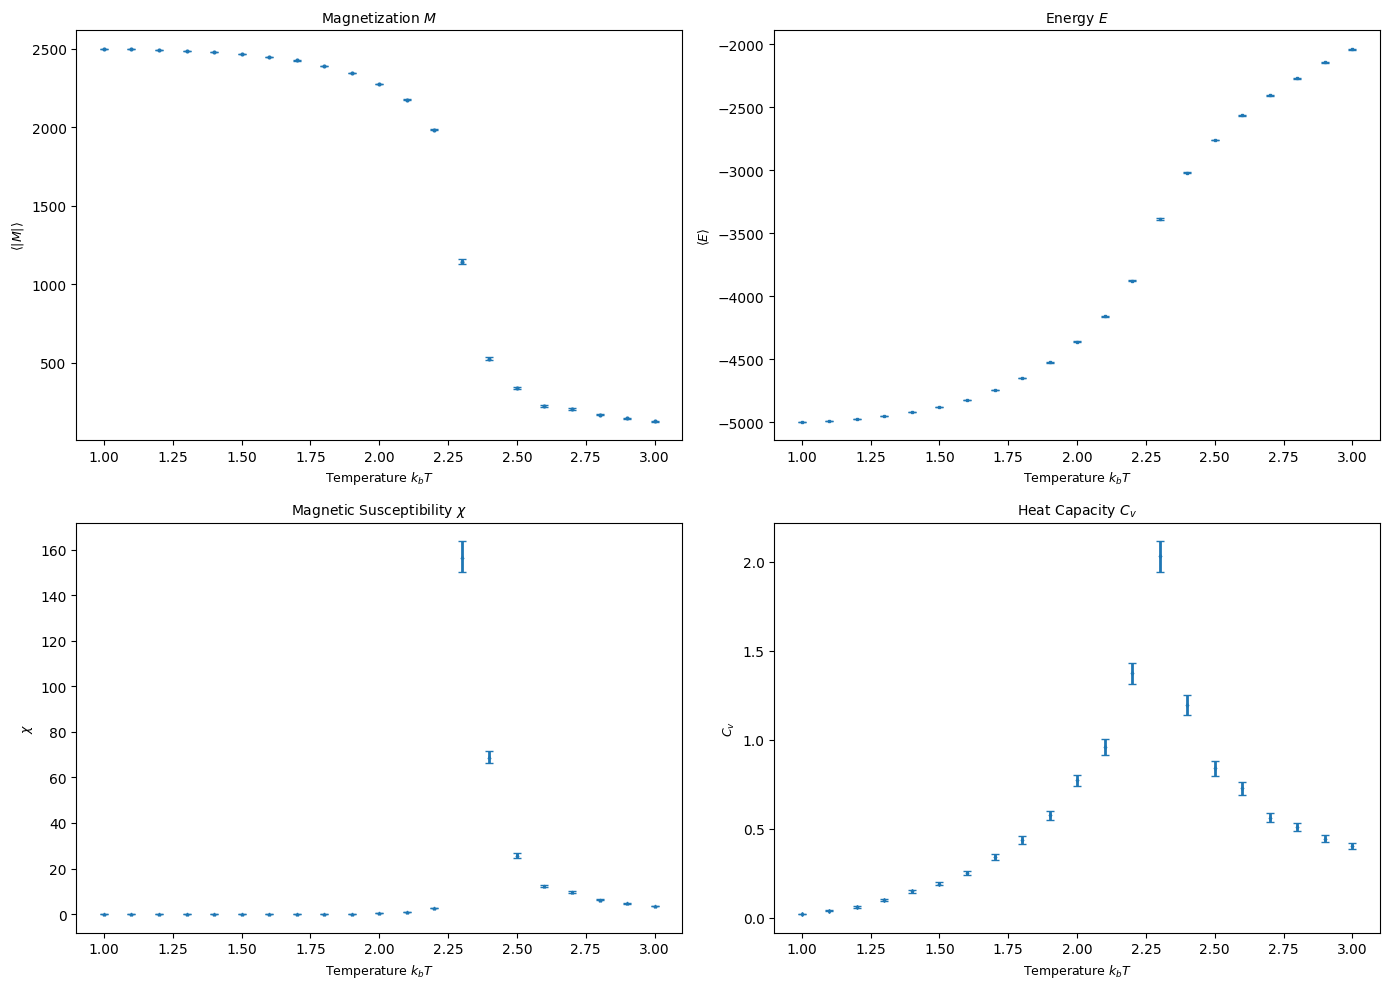

In [10]:
algorithm = "glauber"  # "glauber" or "kawasaki"
direction = "heating"
collect_data(size, iteration, sampling, thermalisation, algorithm, error_analysis, direction, T_max, T_min, T_step)

Average Magnetization: 144.486 Average Energy: -2037.992 Susceptibility: 4.353871453333333 Heat Capacity: 0.40351004159998977
Average Magnetization: 146.002 Average Energy: -2150.084 Susceptibility: 4.562560838068966 Heat Capacity: 0.4583629462069319
Average Magnetization: 166.344 Average Energy: -2272.176 Susceptibility: 6.150534363428571 Heat Capacity: 0.5246400522449226
Average Magnetization: 209.204 Average Energy: -2413.452 Susceptibility: 10.007947851851853 Heat Capacity: 0.5688548530040333
Average Magnetization: 257.99 Average Energy: -2571.62 Susceptibility: 15.323616885538463 Heat Capacity: 0.681185301775168
Average Magnetization: 354.056 Average Energy: -2767.36 Susceptibility: 29.234596055040004 Heat Capacity: 0.8145555455999376
Average Magnetization: 590.784 Average Energy: -3025.72 Susceptibility: 74.23380660000001 Heat Capacity: 1.0844412222222637
Average Magnetization: 1218.638 Average Energy: -3404.872 Susceptibility: 44.80813684800001 Heat Capacity: 2.0198333168998794


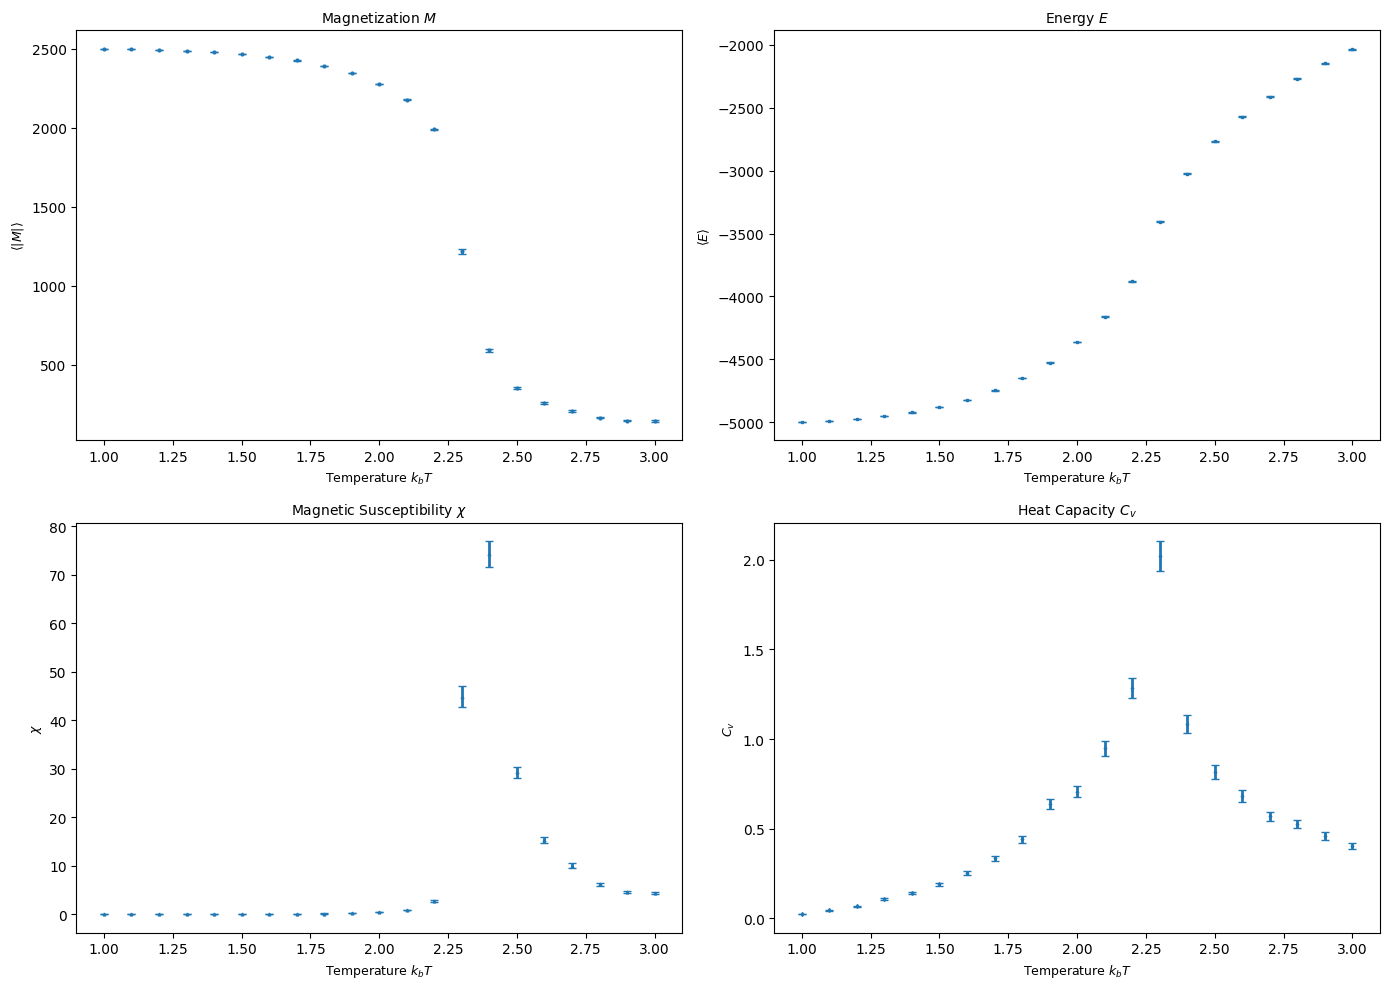

In [11]:
# -----------------------------
# Set parameters
# -----------------------------
algorithm = "glauber"  # "glauber" or "kawasaki"
direction = "cooling"

collect_data(size, iteration, sampling, thermalisation, algorithm, error_analysis, direction, T_max, T_min, T_step)

Average Magnetization: 6.0 Average Energy: -4740.828 Susceptibility: 0.0 Heat Capacity: 0.057997766399383546
Average Magnetization: 6.0 Average Energy: -4717.312 Susceptibility: 0.0 Heat Capacity: 0.07967955570206169
Average Magnetization: 6.0 Average Energy: -4697.744 Susceptibility: 0.0 Heat Capacity: 0.13071068444496226
Average Magnetization: 6.0 Average Energy: -4665.188 Susceptibility: 0.0 Heat Capacity: 0.16322193041443817
Average Magnetization: 6.0 Average Energy: -4628.256 Susceptibility: 0.0 Heat Capacity: 0.17305438040774687
Average Magnetization: 6.0 Average Energy: -4564.188 Susceptibility: 0.0 Heat Capacity: 0.2619585166222518
Average Magnetization: 6.0 Average Energy: -4487.452 Susceptibility: 0.0 Heat Capacity: 0.32122557749971725
Average Magnetization: 6.0 Average Energy: -4407.608 Susceptibility: 0.0 Heat Capacity: 0.4398558250513041
Average Magnetization: 6.0 Average Energy: -4317.624 Susceptibility: 0.0 Heat Capacity: 0.44143242271594024
Average Magnetization: 6.0 Av

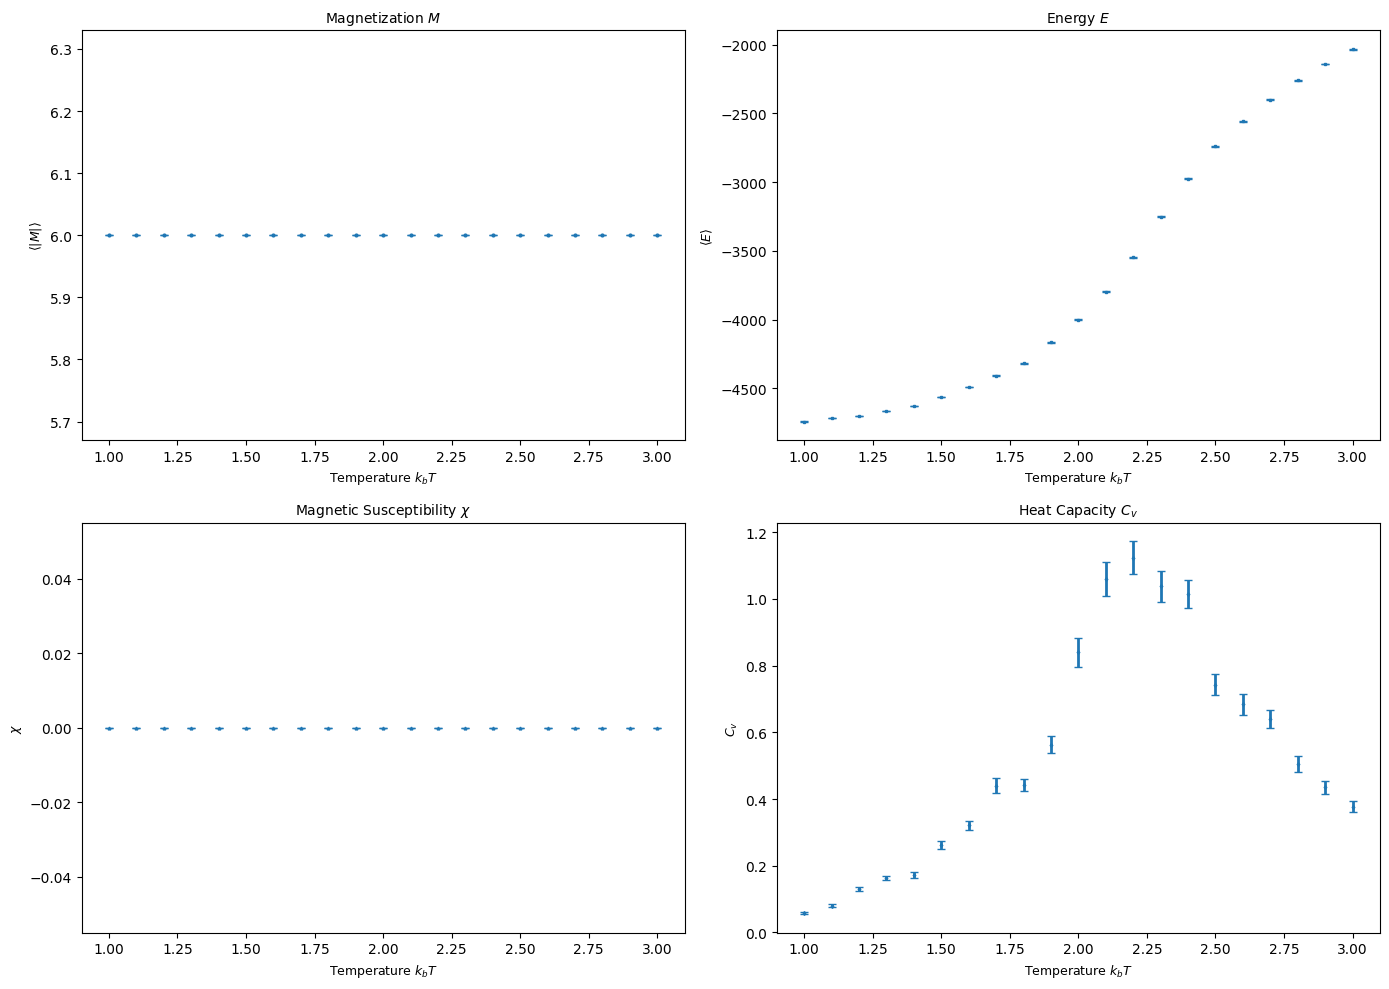

In [12]:
# -----------------------------
# Set parameters
# -----------------------------
algorithm = "kawasaki"  # "glauber" or "kawasaki"
direction = "heating"

collect_data(size, iteration, sampling, thermalisation, algorithm, error_analysis, direction, T_max, T_min, T_step)

Average Magnetization: 54.0 Average Energy: -2035.008 Susceptibility: 0.0 Heat Capacity: 0.3958858638222226
Average Magnetization: 54.0 Average Energy: -2141.628 Susceptibility: 0.0 Heat Capacity: 0.45342847162899735
Average Magnetization: 54.0 Average Energy: -2254.208 Susceptibility: 0.0 Heat Capacity: 0.5145267722448715
Average Magnetization: 54.0 Average Energy: -2406.444 Susceptibility: 0.0 Heat Capacity: 0.6431795261454334
Average Magnetization: 54.0 Average Energy: -2552.584 Susceptibility: 0.0 Heat Capacity: 0.6661611209468113
Average Magnetization: 54.0 Average Energy: -2747.968 Susceptibility: 0.0 Heat Capacity: 0.899442622464061
Average Magnetization: 54.0 Average Energy: -2971.352 Susceptibility: 0.0 Heat Capacity: 0.9888152844444595
Average Magnetization: 54.0 Average Energy: -3230.136 Susceptibility: 0.0 Heat Capacity: 1.2083355390548094
Average Magnetization: 54.0 Average Energy: -3490.884 Susceptibility: 0.0 Heat Capacity: 0.9701357474381279
Average Magnetization: 54.0 

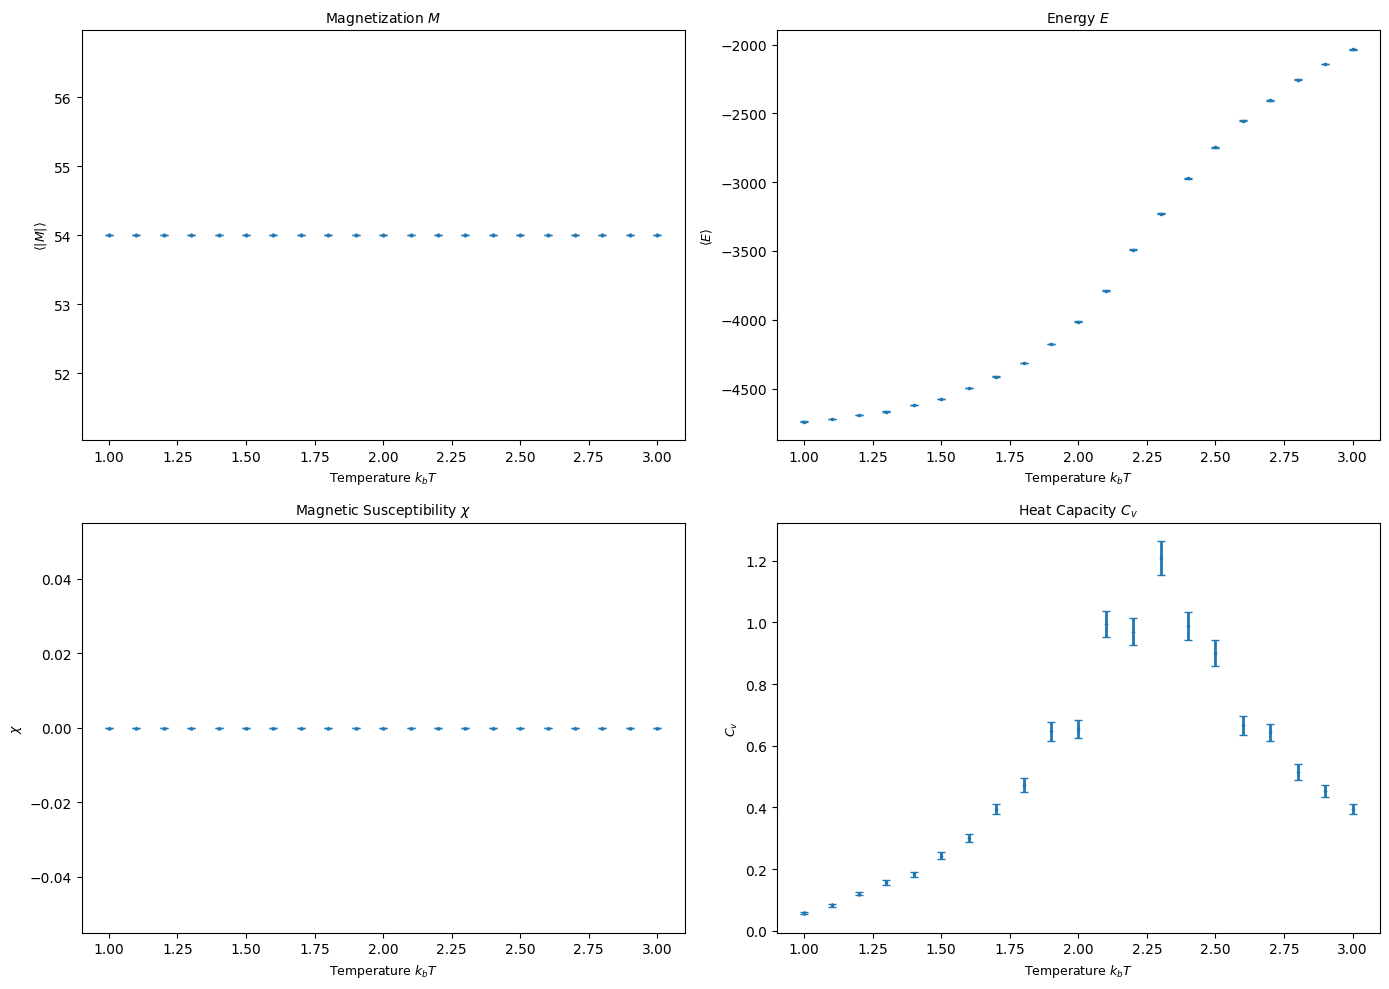

In [13]:
# -----------------------------
# Set parameters
# -----------------------------
algorithm = "kawasaki"  # "glauber" or "kawasaki"
direction = "cooling"

collect_data(size, iteration, sampling, thermalisation, algorithm, error_analysis, direction, T_max, T_min, T_step)